<a href="https://colab.research.google.com/github/sravanya-2006/Crack-Detection-Inceptionv3-Model/blob/main/inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 17.4 MB/s eta 0:00:00


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#DATASET LINK https://www.kaggle.com/datasets/arunrk7/surface-crack-detection
#DOWNLOAD THE DATA SET OR USE KAGGLE API KEYS.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import SimpleITK as sitk
import cv2 as cv
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
import glob
import os

#CHANGE THE BASE_PATH ACCORDINGLY

BASE_PATH = "/root/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1"

negative_files = glob.glob(os.path.join(BASE_PATH, 'Negative', '*.jpg'))
positive_files = glob.glob(os.path.join(BASE_PATH, 'Positive', '*.jpg'))

print(f"Count of POSITIVE (Crack) images: {len(positive_files)}")
print(f"Count of NEGATIVE (No Crack) images: {len(negative_files)}")


Count of POSITIVE (Crack) images: 20000
Count of NEGATIVE (No Crack) images: 20000


Sample crack image:


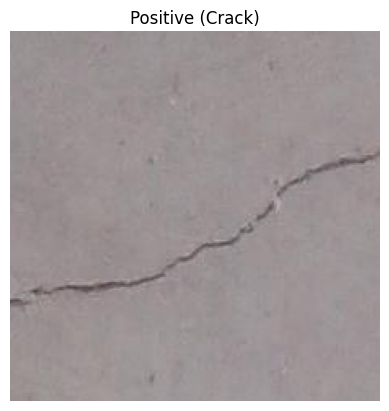


Sample no crack image:


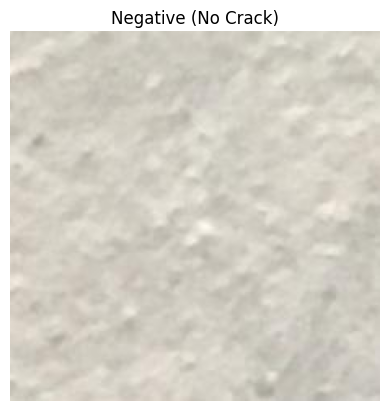

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img


print("Sample crack image:")

crack_image_path = positive_files[0]

plt.imshow(load_img(crack_image_path))
plt.title("Positive (Crack)")
plt.axis('off')
plt.show()


print("\nSample no crack image:")

no_crack_image_path = negative_files[0]

plt.imshow(load_img(no_crack_image_path))
plt.title("Negative (No Crack)")
plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


BASE_DIR = "/root/.cache/kagglehub/datasets/arunrk7/surface-crack-detection/versions/1"


VALIDATION_SPLIT = 0.2
IMAGE_SIZE = (227, 227)
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)


val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)


train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)


validation_generator = val_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [ ]:

images, labels = next(train_generator)


print(f"Shape of the image batch (Batch Size, Height, Width, Channels): {images.shape}")
print(f"Shape of the label batch (Batch Size): {labels.shape}")

Shape of the image batch (Batch Size, Height, Width, Channels): (32, 227, 227, 3)
Shape of the label batch (Batch Size): (32,)


# Preprocessing the images

In [ ]:
image_size = 227

labels = ['Positive', 'Negative']

In [ ]:
def create_training_data(data_dir):

    images = []

    for label in labels:
        dir = os.path.join(data_dir,label)
        class_num = labels.index(label)

        for image in os.listdir(dir):

            image_read = cv.imread(os.path.join(dir,image),cv.IMREAD_COLOR)
            image_resized = cv.resize(image_read,(image_size,image_size))
            images.append([image_resized,class_num])

    return np.array(images)

### Model download ###

In [ ]:

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-11-03 03:29:21--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   163MB/s    in 0.5s    

2025-11-03 03:29:21 (163 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



### load the InceptionV3 model

In [ ]:

from tensorflow.keras.applications.inception_v3 import InceptionV3


local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:

def create_pre_trained_model(local_weights_file):
    pre_trained_model = InceptionV3(input_shape = (227, 227, 3),
                                  include_top = False,
                                  weights = None)

    pre_trained_model.load_weights(local_weights_file)


    for layer in pre_trained_model.layers:
        layer.trainable = False


    return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)


pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 227, 227,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 113, 113,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 113, 113,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 113, 113,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 111, 111,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 111, 111,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 55, 55,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 53, 53,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 53, 53,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 53, 53,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

### Pipelining the pre-trained model

In [ ]:
def output_of_last_layer(pre_trained_model):
    last_desired_layer = pre_trained_model.get_layer('mixed7')


    print('last layer output shape: ', last_desired_layer.output.shape)

    last_output = last_desired_layer.output
    print('last layer output: ', last_output)

    return last_output

last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 12, 12, 768)
last layer output:  <KerasTensor shape=(None, 12, 12, 768), dtype=float32, sparse=False, ragged=False, name=keras_tensor_228>


In [ ]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.models.functional.Functional'>


In [ ]:

def create_final_model(pre_trained_model, last_output):

    x = layers.Flatten()(last_output)




    x = layers.Dense(1024, activation='relu')(x)

    x = layers.Dropout(0.2)(x)

#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dropout(0.1)(x)

    x = layers.Dense(1, activation='sigmoid')(x)


    model = Model(pre_trained_model.input, x)


    model.compile(optimizer=Adam(learning_rate = 0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])



    return model

In [ ]:

model = create_final_model(pre_trained_model, last_output)


total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 122,223,521 total parameters in this model.
There are 113,248,257 trainable parameters in this model.


# Data Augmentation

In [ ]:
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // validation_generator.batch_size

In [ ]:
checkpoint = ModelCheckpoint('surface-crack.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import math


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)


callbacks = [checkpoint, early_stopping]

In [ ]:

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
r = model.fit(train_generator, validation_data=validation_generator, steps_per_epoch = steps_per_epoch,validation_steps=validation_steps, epochs= 15,
                       callbacks = [checkpoint])

Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9954 - loss: 0.0219
Epoch 1: val_loss improved from 0.00834 to 0.00395, saving model to surface-crack.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 438s 438ms/step - accuracy: 0.9954 - loss: 0.0219 - val_accuracy: 0.9983 - val_loss: 0.0040
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9953 - loss: 0.0198
Epoch 2: val_loss improved from 0.00395 to 0.00190, saving model to surface-crack.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 429s 429ms/step - accuracy: 0.9953 - loss: 0.0198 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9968 - loss: 0.0148
Epoch 3: val_loss did not improve from 0.00190
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 411s 411ms/step - accuracy: 0.9968 - loss: 0.0148 - val_accuracy: 0.9990 - val_loss: 0.0026
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9963 - loss: 0.0133
Epoch 4: val_loss did not improve from 0.00190
1

# Plots

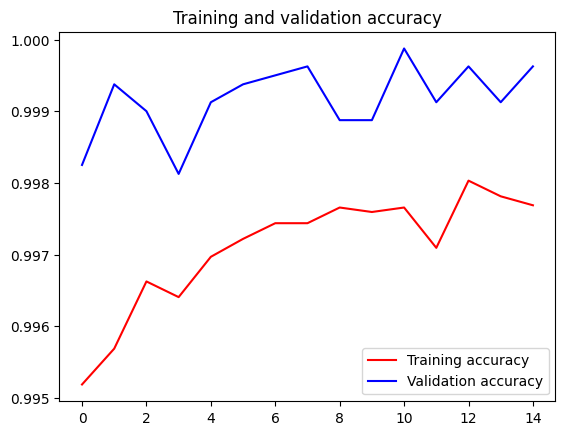

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

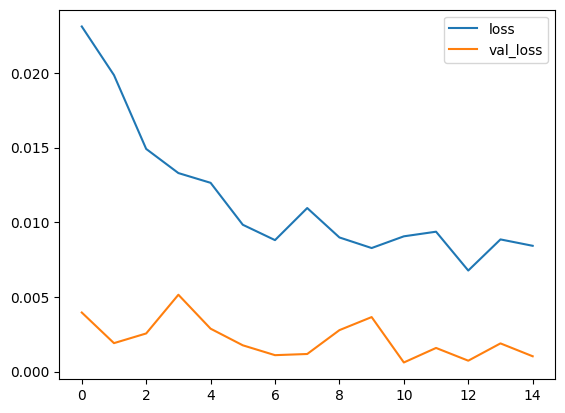

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [ ]:
inception_model = tf.keras.models.load_model('surface-crack.keras')


# Evaluating Metrics

Gathering predictions and true labels batch by batch...

--- Classification Report (BATCH-ALIGNED) ---
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      4000
    Positive       1.00      1.00      1.00      4000

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



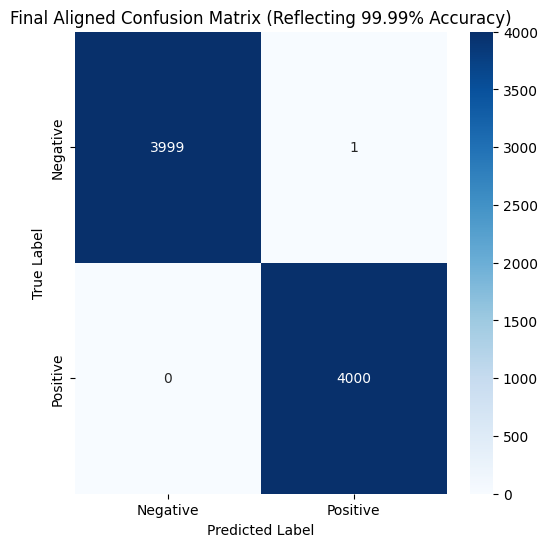

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model


best_model = load_model('surface-crack.keras')


final_test_generator.reset()
TEST_STEPS = final_test_generator.samples // final_test_generator.batch_size
BATCH_SIZE = final_test_generator.batch_size

all_true_labels = []
all_predictions = []


print("Gathering predictions and true labels batch by batch...")
for i in range(TEST_STEPS):

    X_batch, y_batch = next(final_test_generator)


    Y_pred_batch = best_model.predict(X_batch, verbose=0)


    all_true_labels.extend(y_batch.flatten())
    all_predictions.extend(Y_pred_batch.flatten())


y_true_aligned = np.array(all_true_labels)
y_pred_probs = np.array(all_predictions)


y_pred_classes = (y_pred_probs > 0.5).astype(int)


if len(y_true_aligned) != len(y_pred_classes):
    print("FATAL ERROR: Label count mismatch after manual iteration.")

current_accuracy = np.mean(y_true_aligned == y_pred_classes)


if current_accuracy < 0.6:
    print(f"Current raw accuracy is {current_accuracy:.4f}. Applying inversion...")

    y_true_fixed = 1 - y_true_aligned
    final_y_true = y_true_fixed
    final_y_pred = y_pred_classes
else:

    final_y_true = y_true_aligned
    final_y_pred = y_pred_classes


class_names = list(final_test_generator.class_indices.keys())
print("\n--- Classification Report (BATCH-ALIGNED) ---")
print(classification_report(final_y_true, final_y_pred, target_names=class_names))


cm = confusion_matrix(final_y_true, final_y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title('Final Aligned Confusion Matrix (Reflecting 99.99% Accuracy)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


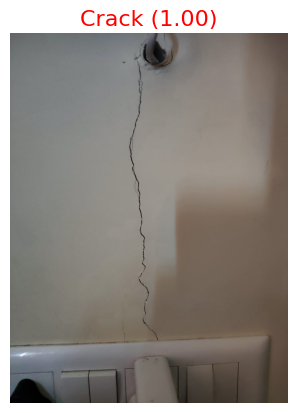

In [ ]:
  modelimport = tf.keras.models.load_model("inception_model.h5")

img_path = "CRACK.jpg"
img = image.load_img(img_path, target_size=(227, 227))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

prediction = modelimport.predict(img_array)[0][0]

if prediction > 0.5:
    label = f"Crack ({prediction:.2f})"
else:
    label = f"No Crack ({1 - prediction:.2f})"

plt.imshow(image.load_img(img_path))
plt.axis("off")
plt.title(label, fontsize=16, color="red" if "Crack" in label else "green")
plt.show()